In [26]:
import pandas as pd
import numpy as np

In [ ]:
training_df = pd.read_pickle("training_df.pkl")

In [28]:
training_df

,0,1
0,"[[795.8723, 1030.5753, 1221.545, 2527.3108], [...",RATOON
1,"[[796.2904, 1030.5753, 1287.7687, 2592.0356], ...",RATOON
2,"[[797.5659, 1035.5573, 1312.4275, 2514.7058], ...",RATOON
3,"[[816.426, 1035.5573, 1318.4069, 2471.8484], [...",RATOON
4,"[[816.426, 1043.4703, 1318.4069, 2440.3352], [...",RATOON
...,...,...
2,"[[613.6827, 837.13464, 703.7508, 2553.2405], [...",SPRING
3,"[[619.5356, 848.07385, 723.65784, 2162.117], [...",SPRING
0,"[[644.2388, 864.4313, 794.69556, 1969.8365], [...",SPRING
1,"[[641.99023, 853.6742, 794.69556, 2026.1615], ...",SPRING


In [33]:
X = np.array(training_df[0].tolist())
X = X*0.0001

###
X.shape
(59312, 23, 4):
sample, time_stamp, features("B2", "B3", "B4", "B8")


In [35]:
crop_map = {"OTHER": 0, "SPRING": 1, "RATOON": 2, 'BARREN': 3, 'BUILTUP': 4, 'WATER': 5, 'PERENNIAL': 6, 'UC': 7}
crop_map

{'OTHER': 0,
 'SPRING': 1,
 'RATOON': 2,
 'BARREN': 3,
 'BUILTUP': 4,
 'WATER': 5,
 'PERENNIAL': 6,
 'UC': 7}

In [37]:
y = training_df[1].map(crop_map)

In [38]:
import tensorflow
from tensorflow.keras.utils import to_categorical

Y = to_categorical(y, num_classes=8)

2026-02-17 14:47:03.386944: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-17 14:47:06.428130: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-17 14:47:30.450880: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [39]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Bidirectional, Dense,
    BatchNormalization, Dropout, Concatenate
)
from tensorflow.keras.models import Model


In [40]:
timesteps = 23
optical_features = 4
num_classes = 8


In [41]:
optical_input = Input(shape=(timesteps, optical_features), name="optical_input")

x_opt = Bidirectional(
    LSTM(
        100,
        return_sequences=True,
        dropout=0.0,
        recurrent_dropout=0.2
    )
)(optical_input)

x_opt = Bidirectional(
    LSTM(
        100,
        return_sequences=False,
        dropout=0.0,
        recurrent_dropout=0.2
    )
)(x_opt)

x_opt = BatchNormalization()(x_opt)
fc = Dense(100, activation="relu")(x_opt)
fc = BatchNormalization()(fc)
fc = Dropout(0.5)(fc)
output = Dense(num_classes, activation="softmax", name="output")(fc)


2026-02-17 14:48:35.151264: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [43]:
model = Model(
    inputs=optical_input,
    outputs=output
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ optical_input (InputLayer)      │ (None, 23, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 23, 200)        │        84,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │           808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,908 (1.32 MB)

 Trainable params: 346,308 (1.32 MB)

 Non-trainable params: 600 (2.34 KB)

In [45]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [47]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    shuffle=True
)


Epoch 1/80
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 80s 41ms/step - accuracy: 0.8135 - loss: 0.5868 - val_accuracy: 0.8641 - val_loss: 0.4149
Epoch 2/80
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 74s 41ms/step - accuracy: 0.8847 - loss: 0.3576 - val_accuracy: 0.7493 - val_loss: 0.8976
Epoch 3/80
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 73s 41ms/step - accuracy: 0.9014 - loss: 0.2994 - val_accuracy: 0.8812 - val_loss: 0.4040
Epoch 4/80
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 75s 42ms/step - accuracy: 0.9133 - loss: 0.2636 - val_accuracy: 0.9382 - val_loss: 0.1822
Epoch 5/80
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 76s 42ms/step - accuracy: 0.9228 - loss: 0.2404 - val_accuracy: 0.9270 - val_loss: 0.2182
Epoch 6/80
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 76s 42ms/step - accuracy: 0.9286 - loss: 0.2214 - val_accuracy: 0.9469 - val_loss: 0.1567
Epoch 7/80
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 77s 43ms/step - accuracy: 0.9334 - loss: 0.2056 - val_accuracy: 0.9414 - val_loss: 0.1734
Epoch 8/80
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 78s 43ms/step - accuracy: 0.9408 -

In [ ]:
model.save("lstm.keras")

In [49]:
performance = pd.DataFrame(history.history)

In [ ]:
performance.to_csv("Accuracy_assesment.csv", index=False)

In [50]:
performance

,accuracy,loss,val_accuracy,val_loss
0,0.813542,0.586830,0.864105,0.414900
1,0.884747,0.357559,0.749325,0.897620
2,0.901449,0.299351,0.881205,0.404048
3,0.913339,0.263612,0.938179,0.182234
4,0.922841,0.240415,0.926964,0.218154
...,...,...,...,...
75,0.991363,0.026596,0.993700,0.017970
76,0.991536,0.025754,0.991277,0.026369
77,0.991381,0.025976,0.993493,0.019863
78,0.991744,0.025697,0.994462,0.018889


In [ ]:
performance.to_csv("Accuracy_assesment.csv", index=False)

Text(0.5, 1.0, 'Loss')

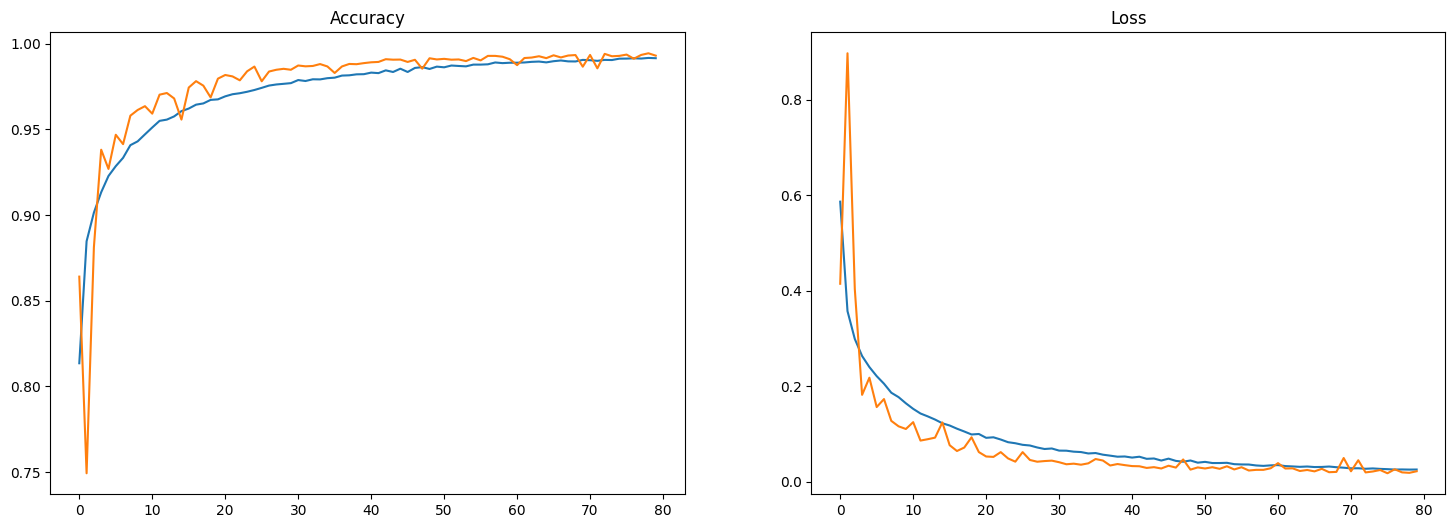

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(performance['accuracy'], label="Training Accuracy")
plt.plot(performance['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(performance['loss'], label="Trainin Loss")
plt.plot(performance['val_loss'], label="Validation Loss")
plt.title('Loss')